### Import bibliotek

In [24]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

### Deklaracja danych

In [25]:
def F1(u):
    x, y = u
    return x**2 + y**2

def F2(u):
    x, y = u
    return (x - 1)**2 + (y + 1)**2

def objectives(u):
    return np.array([F1(u), F2(u)])

U = [(-1, 1), (-1, 1)]  # Dziedzina U - kwadrat

# Generacja zakresu dla funkcji
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

# Funkcje nieliniowe


### Definicja funkcji celu

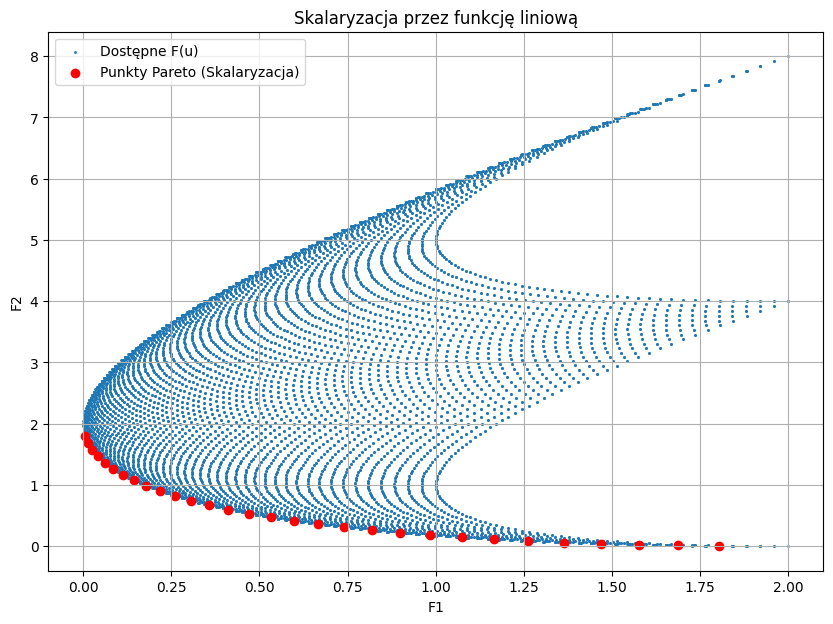

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

def gradient_descent(objective, gradient, u0, bounds, learning_rate=0.05, max_iters=1000, tol=1e-6):
    u = np.array(u0, dtype=float)
    for i in range(max_iters):
        grad = gradient(u)
        u_new = u - learning_rate * grad

        # Projekcja u_new na ograniczenia
        for j in range(len(u)):
            u_new[j] = np.clip(u_new[j], bounds[j][0], bounds[j][1])

        # Sprawdzenie zbieżności
        if np.linalg.norm(u_new - u) < tol:
            break

        u = u_new

    return u

def grad_F1(u):
    x, y = u
    return np.array([2 * x, 2 * y])

def grad_F2(u):
    x, y = u
    return np.array([2 * (x - 1), 2 * (y + 1)])

def scalarization_linear_objective(u, lambd):
    lambda1, lambda2 = lambd
    return lambda1 * F1(u) + lambda2 * F2(u)

def scalarization_linear_gradient(u, lambd):
    lambda1, lambda2 = lambd
    return lambda1 * grad_F1(u) + lambda2 * grad_F2(u)

def scalarization_linear(u0, lambd):
    def objective(u):
        return scalarization_linear_objective(u, lambd)

    def gradient(u):
        return scalarization_linear_gradient(u, lambd)

    bounds = [(-1, 1), (-1, 1)]
    u_opt = gradient_descent(objective, gradient, u0, bounds)
    return u_opt

# Generowanie rozwiązań
lambda_values = np.linspace(0.05, 0.95, 30)
solutions = []

for lambda1 in lambda_values:
    lambd = np.array([lambda1, 1 - lambda1])
    u_opt = scalarization_linear(u0=[0, 0], lambd=lambd)
    solutions.append((u_opt, np.array([F1(u_opt), F2(u_opt)])))

F_values = np.array([sol[1] for sol in solutions])

# Generowanie przestrzeni funkcji celu
x_vals = np.linspace(-1, 1, 100)
y_vals = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_vals, y_vals)
U_grid = np.column_stack([X.ravel(), Y.ravel()])
F_all = np.array([objectives(u) for u in U_grid])

# Wizualizacja
plt.figure(figsize=(10, 7))
plt.scatter(F_all[:, 0], F_all[:, 1], s=1, label='Dostępne F(u)')
plt.scatter(F_values[:, 0], F_values[:, 1], color='red', label='Punkty Pareto (Skalaryzacja)')

plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Skalaryzacja przez funkcję liniową')
plt.legend()
plt.grid(True)
plt.show()


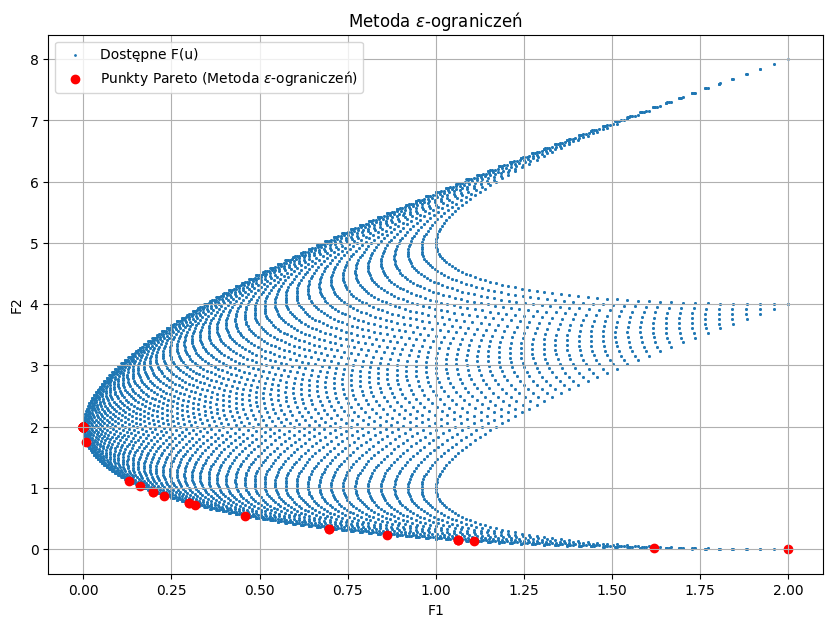

In [27]:
def epsilon_constraint_objective(u, epsilon, penalty_coefficient=1000):
    f1_value = F1(u)
    f2_value = F2(u)
    penalty = penalty_coefficient * max(0, f2_value - epsilon)**2
    return f1_value + penalty

def epsilon_constraint_gradient(u, epsilon, penalty_coefficient=1000):
    grad = grad_F1(u)
    f2_value = F2(u)
    if f2_value > epsilon:
        penalty_grad = penalty_coefficient * 2 * (f2_value - epsilon) * grad_F2(u)
        grad += penalty_grad
    return grad

def epsilon_constraint_optimization(u0, epsilon):
    def objective(u):
        return epsilon_constraint_objective(u, epsilon)

    def gradient(u):
        return epsilon_constraint_gradient(u, epsilon)

    bounds = [(-1, 1), (-1, 1)]
    u_opt = gradient_descent(objective, gradient, u0, bounds)
    return u_opt

# Generowanie rozwiązań
epsilon_values = np.linspace(np.min(F_all[:, 1]), np.max(F_all[:, 1]), 75)
solutions = []

for epsilon in epsilon_values:
    u_opt = epsilon_constraint_optimization(u0=[0, 0], epsilon=epsilon)
    solutions.append((u_opt, np.array([F1(u_opt), F2(u_opt)])))

F_values = np.array([sol[1] for sol in solutions])

# Wizualizacja
plt.figure(figsize=(10, 7))
plt.scatter(F_all[:, 0], F_all[:, 1], s=1, label='Dostępne F(u)')
plt.scatter(F_values[:, 0], F_values[:, 1], color='red', label='Punkty Pareto (Metoda $\epsilon$-ograniczeń)')
plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Metoda $\epsilon$-ograniczeń')
plt.legend()
plt.grid(True)
plt.show()


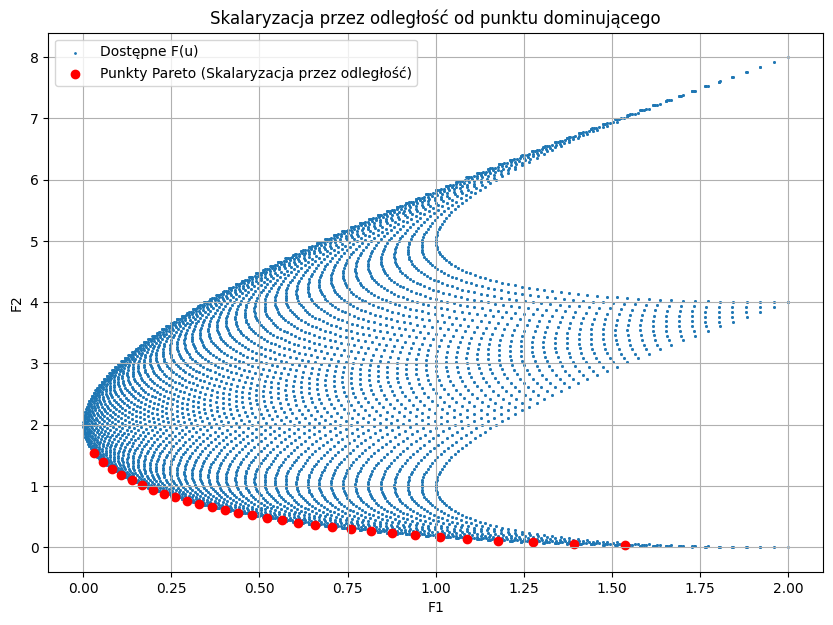

In [28]:
def scalarization_distance_objective(u, x_dominating, lambd):
    diff = np.array([F1(u) - x_dominating[0], F2(u) - x_dominating[1]])
    weighted_diff = lambd * diff
    return np.linalg.norm(weighted_diff)

def scalarization_distance_gradient(u, x_dominating, lambd):
    diff = np.array([F1(u) - x_dominating[0], F2(u) - x_dominating[1]])
    weighted_diff = lambd * diff
    D_u = np.linalg.norm(weighted_diff)
    if D_u == 0:
        return np.zeros_like(u)
    grad = (lambd[0]**2 * (F1(u) - x_dominating[0]) * grad_F1(u) +
            lambd[1]**2 * (F2(u) - x_dominating[1]) * grad_F2(u)) / D_u
    return grad

def scalarization_distance(u0, x_dominating, lambd):
    def objective(u):
        return scalarization_distance_objective(u, x_dominating, lambd)

    def gradient(u):
        return scalarization_distance_gradient(u, x_dominating, lambd)

    bounds = [(-1, 1), (-1, 1)]
    u_opt = gradient_descent(objective, gradient, u0, bounds)
    return u_opt

# Generowanie rozwiązań
dominating_point = np.array([0, 0])  # Punkt dominujący
lambda_values = np.linspace(0.05, 0.95, 30)
solutions = []

for lambda1 in lambda_values:
    lambd = np.array([lambda1, 1 - lambda1])
    u_opt = scalarization_distance(u0=[0, 0], x_dominating=dominating_point, lambd=lambd)
    solutions.append((u_opt, np.array([F1(u_opt), F2(u_opt)])))

F_values = np.array([sol[1] for sol in solutions])

# Wizualizacja
plt.figure(figsize=(10, 7))
plt.scatter(F_all[:, 0], F_all[:, 1], s=1, label='Dostępne F(u)')
plt.scatter(F_values[:, 0], F_values[:, 1], color='red', label='Punkty Pareto (Skalaryzacja przez odległość)')
plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Skalaryzacja przez odległość od punktu dominującego')
plt.legend()
plt.grid(True)
plt.show()


### Rozszerzenie na Problem z Trzema Kryteriami

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def G1(u):
    x, y, z = u
    return x**2 + y**2 + z**2

def G2(u):
    x, y, z = u
    return (x - 1)**2 + (y + 1)**2 + z**2

def G3(u):
    x, y, z = u
    return x**3 + y**3 + z**3

def grad_G1(u):
    x, y, z = u
    return np.array([2 * x, 2 * y, 2 * z])

def grad_G2(u):
    x, y, z = u
    return np.array([2 * (x - 1), 2 * (y + 1), 2 * z])

def grad_G3(u):
    x, y, z = u
    return np.array([3 * x**2, 3 * y**2, 3 * z**2])

def objectives(u):
    return np.array([G1(u), G2(u), G3(u)])


In [30]:
from itertools import product

# Generowanie siatki punktów w dziedzinie U
num_points = 20
u_vals = np.linspace(-1, 1, num_points)
U_grid = np.array(list(product(u_vals, repeat=3)))

# Obliczanie wartości funkcji celu dla każdego punktu w U
G_all = np.array([objectives(u) for u in U_grid])


###  Implementacja algorytmu gradientu prostego

In [31]:
def gradient_descent_n(objective, gradient, u0, bounds, learning_rate=0.01, max_iters=5000, tol=1e-8):
    u = np.array(u0, dtype=float)
    for i in range(max_iters):
        grad = gradient(u)
        u_new = u - learning_rate * grad

        # Projekcja u_new na ograniczenia
        for j in range(len(u)):
            u_new[j] = np.clip(u_new[j], bounds[j][0], bounds[j][1])

        # Sprawdzenie zbieżności
        if np.linalg.norm(u_new - u) < tol:
            break

        u = u_new

    return u


###  Implementacja Skalaryzacji przez Funkcję Liniową

In [32]:
def scalarization_linear_objective_n(u, lambd):
    G_values = objectives(u)
    return np.dot(lambd, G_values)

def scalarization_linear_gradient_n(u, lambd):
    grad_G_values = np.array([grad_G1(u), grad_G2(u), grad_G3(u)])
    return np.dot(lambd, grad_G_values)


In [33]:
def scalarization_linear_n(u0, lambd):
    def objective(u):
        return scalarization_linear_objective_n(u, lambd)

    def gradient(u):
        return scalarization_linear_gradient_n(u, lambd)

    bounds = [(-1, 1), (-1, 1), (-1, 1)]
    u_opt = gradient_descent_n(objective, gradient, u0, bounds)
    return u_opt


In [34]:
# Generowanie kombinacji lambda
lambda_values = np.linspace(0.1, 0.9, 5)
solutions = []
print(lambda_values)
for lambda1 in lambda_values:
    for lambda2 in lambda_values:
        lambda3 = 1.0 - lambda1 - lambda2
        if lambda3 >= 0:
            lambd = np.array([lambda1, lambda2, lambda3])
            u_opt = scalarization_linear_n(u0=[0, 0, 0], lambd=lambd)
            G_opt = objectives(u_opt)
            solutions.append((u_opt, G_opt))


[0.1 0.3 0.5 0.7 0.9]


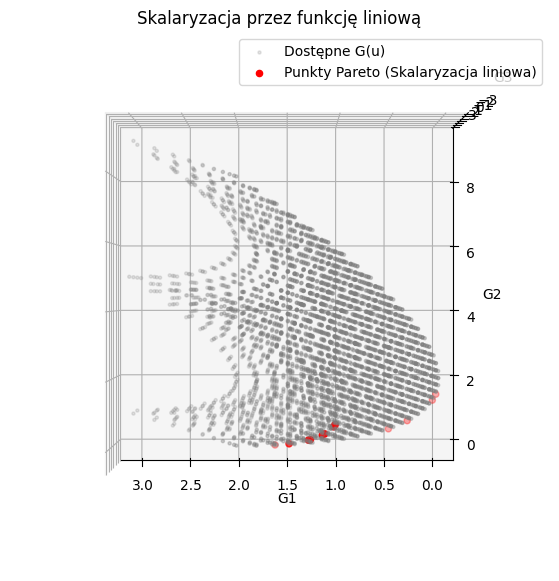

In [35]:
G_pareto = np.array([sol[1] for sol in solutions])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Wszystkie dostępne wartości G(u)
ax.scatter(G_all[:, 0], G_all[:, 1], G_all[:, 2], s=5, color='gray', alpha=0.2, label='Dostępne G(u)')

# Punkty Pareto
ax.scatter(G_pareto[:, 0], G_pareto[:, 1], G_pareto[:, 2], color='red', label='Punkty Pareto (Skalaryzacja liniowa)')

ax.set_xlabel('G1')
ax.set_ylabel('G2')
ax.set_zlabel('G3')
ax.set_title('Skalaryzacja przez funkcję liniową')
ax.legend()
ax.view_init(270, 270)
plt.show()



### Implementacja Metody ϵ-Ograniczeń

In [36]:
def epsilon_constraint_objective_n(u, epsilons, penalty_coefficient=1000):
    G_values = objectives(u)
    penalty = penalty_coefficient * sum(max(0, G_values[i+1] - epsilons[i])**2 for i in range(2))
    return G_values[0] + penalty

def epsilon_constraint_gradient_n(u, epsilons, penalty_coefficient=1000):
    grad = grad_G1(u)
    G_values = objectives(u)
    grad_G_values = np.array([grad_G1(u), grad_G2(u), grad_G3(u)])
    for i in range(2):
        if G_values[i+1] > epsilons[i]:
            penalty_grad = penalty_coefficient * 2 * (G_values[i+1] - epsilons[i]) * grad_G_values[i+1]
            grad += penalty_grad
    return grad

def epsilon_constraint_optimization_n(u0, epsilons):
    def objective(u):
        return epsilon_constraint_objective_n(u, epsilons)

    def gradient(u):
        return epsilon_constraint_gradient_n(u, epsilons)

    bounds = [(-1, 1), (-1, 1), (-1, 1)]
    u_opt = gradient_descent_n(objective, gradient, u0, bounds)
    return u_opt

# Generowanie wartości epsilon
epsilon_values = np.linspace(np.min(G_all[:, 1:]), np.max(G_all[:, 1:]), 10)
solutions = []

for epsilon2 in epsilon_values:
    for epsilon3 in epsilon_values:
        epsilons = [epsilon2, epsilon3]
        u_opt = epsilon_constraint_optimization_n(u0=[0, 0, 0], epsilons=epsilons)
        G_opt = objectives(u_opt)
        solutions.append((u_opt, G_opt))

# Ekstrakcja wartości G dla punktów Pareto
G_pareto = np.array([sol[1] for sol in solutions])


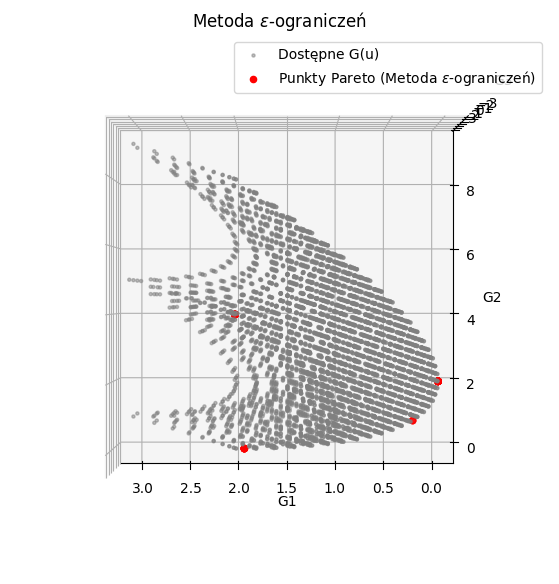

In [37]:
# Wizualizacja 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Wszystkie dostępne wartości G(u)
ax.scatter(G_all[:, 0], G_all[:, 1], G_all[:, 2], s=5, color='gray', alpha=0.5, label='Dostępne G(u)')

# Punkty Pareto
ax.scatter(G_pareto[:, 0], G_pareto[:, 1], G_pareto[:, 2], color='red', label='Punkty Pareto (Metoda $\epsilon$-ograniczeń)')

ax.set_xlabel('G1')
ax.set_ylabel('G2')
ax.set_zlabel('G3')
ax.set_title('Metoda $\epsilon$-ograniczeń')
ax.legend()
ax.view_init(270, 270)
plt.show()


###  Implementacja Skalaryzacji przez Odległość

In [38]:
def scalarization_distance_objective_n(u, x_dominating, lambd):
    G_values = objectives(u)
    diff = G_values - x_dominating
    weighted_diff = lambd * diff
    return np.linalg.norm(weighted_diff)

def scalarization_distance_gradient_n(u, x_dominating, lambd):
    G_values = objectives(u)
    diff = G_values - x_dominating
    weighted_diff = lambd * diff
    D_u = np.linalg.norm(weighted_diff)
    if D_u == 0:
        return np.zeros_like(u)
    grad = np.zeros_like(u)
    grad_G_values = np.array([grad_G1(u), grad_G2(u), grad_G3(u)])
    for i in range(3):
        grad += (lambd[i]**2 * (G_values[i] - x_dominating[i]) * grad_G_values[i]) / D_u
    return grad

def scalarization_distance_n(u0, x_dominating, lambd):
    def objective(u):
        return scalarization_distance_objective_n(u, x_dominating, lambd)

    def gradient(u):
        return scalarization_distance_gradient_n(u, x_dominating, lambd)

    bounds = [(-1, 1), (-1, 1), (-1, 1)]
    u_opt = gradient_descent_n(objective, gradient, u0, bounds)
    return u_opt

# Punkt dominujący
dominating_point = np.array([0, 0, 0])

# Generowanie kombinacji lambda
lambda_values = np.linspace(0.1, 0.9, 10)
solutions = []

for lambda1 in lambda_values:
    for lambda2 in lambda_values:
        lambda3 = 1.0 - lambda1 - lambda2
        if lambda3 >= 0 and lambda3 <= 1:
            lambd = np.array([lambda1, lambda2, lambda3])
            u_opt = scalarization_distance_n(u0=[0, 0, 0], x_dominating=dominating_point, lambd=lambd)
            G_opt = objectives(u_opt)
            solutions.append((u_opt, G_opt))

# Ekstrakcja wartości G dla punktów Pareto
G_pareto = np.array([sol[1] for sol in solutions])


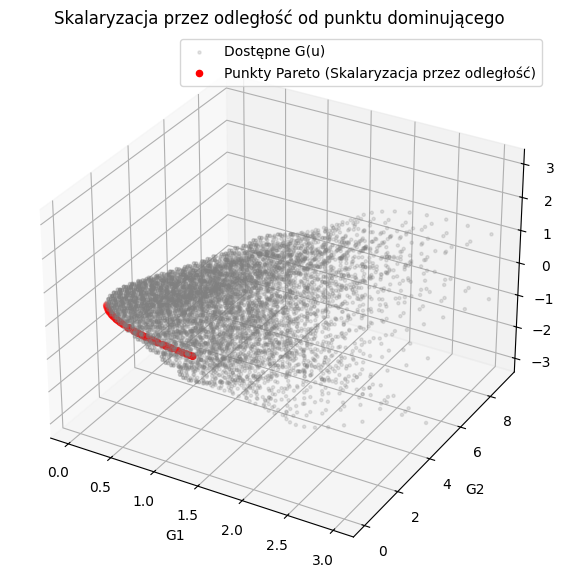

In [40]:
# Wizualizacja 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Wszystkie dostępne wartości G(u)
ax.scatter(G_all[:, 0], G_all[:, 1], G_all[:, 2], s=5, color='gray', alpha=0.2, label='Dostępne G(u)')

# Punkty Pareto
ax.scatter(G_pareto[:, 0], G_pareto[:, 1], G_pareto[:, 2], color='red', label='Punkty Pareto (Skalaryzacja przez odległość)')

ax.set_xlabel('G1')
ax.set_ylabel('G2')
ax.set_zlabel('G3')
ax.set_title('Skalaryzacja przez odległość od punktu dominującego')
ax.legend()
plt.show()
